<a href="https://colab.research.google.com/github/reshini25/Sarcasm-Detection/blob/main/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📥 Downloading sarcasm datasets...
Using Colab cache for faster access to the 'news-headlines-dataset-for-sarcasm-detection' dataset.

✅ All datasets loaded successfully!
Data 1 shape: (26709, 3)
Data 2 shape: (28619, 3)
Data 3 shape: (442638, 10)

✅ Combined dataset created!
Total samples: 497952


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



✅ Text cleaned successfully!
                                                text  \
0  former versace store clerk sues over secret 'b...   
1  the 'roseanne' revival catches up to our thorn...   
2  mom starting to fear son's web series closest ...   
3  boehner just wants wife to listen, not come up...   
4  j.k. rowling wishes snape happy birthday in th...   

                                          clean_text  label  
0  former versace store clerk sues secret black c...      0  
1  roseanne revival catches thorny political mood...      0  
2  mom starting fear sons web series closest thin...      1  
3  boehner wants wife listen come alternative deb...      1  
4  jk rowling wishes snape happy birthday magical...      0  

✅ Data split complete!
Training samples: 398361
Testing samples: 99591

🔹 Training Naive Bayes...
Naive Bayes Accuracy: 0.6600
              precision    recall  f1-score   support

           0       0.65      0.81      0.72     53481
           1       0.69 

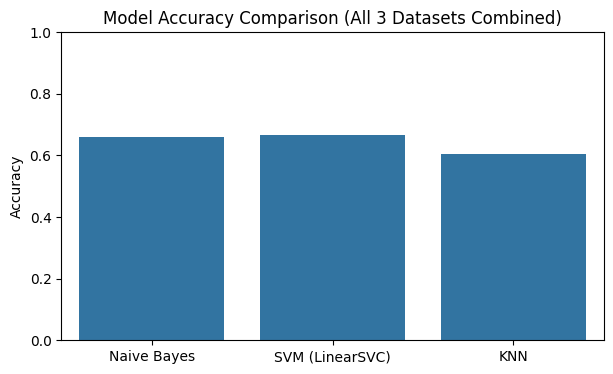


🏆 Best Model: SVM (LinearSVC) (0.6667 accuracy)

🎯 Sample Tests:
'Oh great, another rainy day!' → 😏 Sarcastic
'I love when my phone dies in the middle of a call.' → 🙂 Not Sarcastic
'This cake is delicious!' → 🙂 Not Sarcastic
'The internet is so fast today!' → 🙂 Not Sarcastic
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://619eabfaaab1173ad6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# =========================================================
# 📘 SARCASM DETECTION USING NLP & SUPERVISED LEARNING
# =========================================================

# ✅ Step 0: Install and import required libraries
!pip install kagglehub scikit-learn pandas numpy matplotlib seaborn nltk gradio --quiet

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import kagglehub
import gradio as gr

# =========================================================
# ✅ Step 1: Download & Load All Datasets
# =========================================================
print("📥 Downloading sarcasm datasets...")

# Dataset 1 & 2: News Headlines Sarcasm Detection (Kaggle)
path = kagglehub.dataset_download('rmisra/news-headlines-dataset-for-sarcasm-detection')

data_1 = pd.read_json(f"{path}/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json(f"{path}/Sarcasm_Headlines_Dataset_v2.json", lines=True)

# Dataset 3: Balanced Reddit Sarcasm Dataset (Already in Colab)
data_3_path = "/content/train-balanced-sarcasm.csv"
if os.path.exists(data_3_path):
    # Added error handling for parsing issues
    data_3 = pd.read_csv(data_3_path, on_bad_lines='skip', low_memory=False)
else:
    raise FileNotFoundError("❌ /content/train-balanced-sarcasm.csv not found. Upload it first.")

print("\n✅ All datasets loaded successfully!")
print("Data 1 shape:", data_1.shape)
print("Data 2 shape:", data_2.shape)
print("Data 3 shape:", data_3.shape)

# =========================================================
# ✅ Step 2: Combine Datasets into a Single Format
# =========================================================
# Rename columns to match
data_1 = data_1.rename(columns={'headline': 'text', 'is_sarcastic': 'label'})
data_2 = data_2.rename(columns={'headline': 'text', 'is_sarcastic': 'label'})
data_3 = data_3.rename(columns={'comment': 'text', 'label': 'label'})

# Keep only required columns
data_1 = data_1[['text', 'label']].dropna()
data_2 = data_2[['text', 'label']].dropna()
data_3 = data_3[['text', 'label']].dropna()

# Merge all datasets
data = pd.concat([data_1, data_2, data_3], ignore_index=True)
print("\n✅ Combined dataset created!")
print("Total samples:", data.shape[0])

# =========================================================
# ✅ Step 3: Data Cleaning
# =========================================================
nltk.download('stopwords')
from nltk.corpus import stopwords

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

data['clean_text'] = data['text'].apply(clean_text)

print("\n✅ Text cleaned successfully!")
print(data[['text', 'clean_text', 'label']].head())

# =========================================================
# ✅ Step 4: TF-IDF Feature Engineering
# =========================================================
vectorizer = TfidfVectorizer(max_features=7000)
X = vectorizer.fit_transform(data['clean_text'])
y = data['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n✅ Data split complete!")
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# =========================================================
# ✅ Step 5: Model Training & Evaluation
# =========================================================
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM (LinearSVC)": LinearSVC(),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    results[name] = acc

# =========================================================
# ✅ Step 6: Compare Model Performance
# =========================================================
plt.figure(figsize=(7,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison (All 3 Datasets Combined)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name} ({results[best_model_name]:.4f} accuracy)")

# =========================================================
# ✅ Step 7: Interactive Prediction Function
# =========================================================
def predict_sarcasm(text):
    cleaned = clean_text(text)
    features = vectorizer.transform([cleaned])
    pred = best_model.predict(features)[0]
    return "😏 Sarcastic" if pred == 1 else "🙂 Not Sarcastic"

# Manual test
print("\n🎯 Sample Tests:")
samples = [
    "Oh great, another rainy day!",
    "I love when my phone dies in the middle of a call.",
    "This cake is delicious!",
    "The internet is so fast today!"
]
for s in samples:
    print(f"'{s}' → {predict_sarcasm(s)}")

# =========================================================
# ✅ Step 8: Gradio Interface
# =========================================================
interface = gr.Interface(
    fn=predict_sarcasm,
    inputs=gr.Textbox(lines=2, placeholder="Enter a statement..."),
    outputs="text",
    title="🧠 Sarcasm Detection Model",
    description="Type any sentence to detect if it’s sarcastic or not."
)

interface.launch(share=True)